In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

import glob
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
import pdb
def EPR(EPRfiles,Pfiles):
    files = glob.glob(EPRfiles)
    #pdb.set_trace()
    pseq = np.loadtxt(Pfiles)
    d_sum = np.zeros((pseq.shape[0],))
    l = pseq.shape[0]
    for f in files:
        epr = np.loadtxt(f)
        diff = (epr[:,0]-epr[:,1])/epr[:,1]
        diff[np.isinf(diff)] = 0
        diff = np.nan_to_num(diff)
        diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
        diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
        d_sum += np.mean(diff,axis=1)
        
    return pseq,d_sum/len(files)


def RabiFit(t,a,f,phi,T1,c):
    return a*np.exp(-t/T1)*np.cos(2*np.pi*f*(t+phi))+c

In [5]:
fits = np.zeros((17,5))

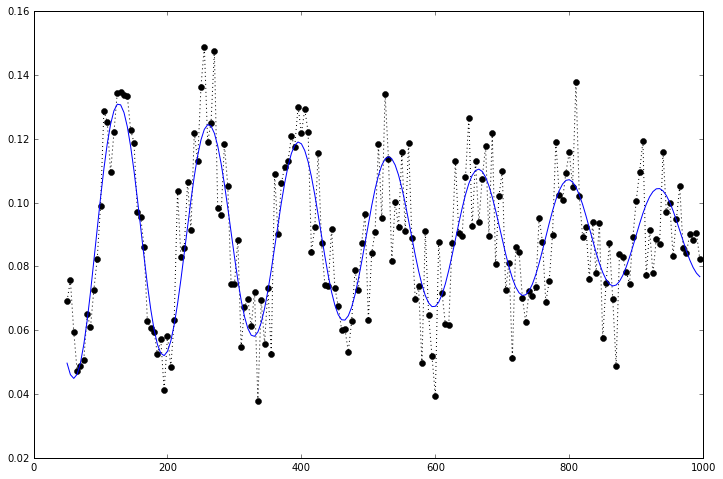

In [159]:
time,rabi0 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x82 y105 1500 sec 0.414000 V  *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x82 y105 1500 sec 0.414000 V   Pulse Seq')

opt0,cov0 = curve_fit(RabiFit,time,rabi0,maxfev=2500,p0=(0.6,9E-3,0,2000,0.09))
plt.plot(time,rabi0,'ko:')
plt.plot(time,RabiFit(time,*opt0),'b-')


In [7]:
time,rabi1 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x94 y92 1500 sec 1.138000 V  *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x94 y92 1500 sec 1.138000 V   Pulse Seq')
p_0=(10,6E-3,0,4000,9)
bound = ([0,1E-4,-200,100,-15],[20,1E-1,200,5E4,15])
opt1,cov1 = curve_fit(RabiFit,time,rabi1,p0=p_0,bounds=bound,maxfev=2500)
plt.plot(time,rabi1,'ko:')
plt.plot(time,RabiFit(time,*opt1),'b-')


TypeError: least_squares() got an unexpected keyword argument 'maxfev'

In [ ]:
sp = np.fft.fft(rabi4)
freq = np.fft.fftfreq(time.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

In [ ]:
from scipy import signal
fs = 1/(time[2]-time[1])*10E9
f, Pxx_den = signal.periodogram(rabi0,fs)
plt.semilogy(f[1:], Pxx_den[1:])

In [ ]:
time,rabi4 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW upper branch Rabi x78 y113 1500 sec 0.310000 V *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW upper branch Rabi x78 y113 1500 sec 0.310000 V   Pulse Seq')

opt4,cov4 = curve_fit(RabiFit,time,rabi4,maxfev=2500,p0=(0.6,9E-3,0,2000,0.09))
plt.plot(time,rabi4,'ko:')
plt.plot(time,RabiFit(time,*opt4),'b-')
print opt4

In [8]:
import re
base = r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  '
files = glob.glob(base+'*')
regex = re.compile(re.escape(base)+'(x\d+ y\d+) 1500 sec (\d+\.\d+) V   \d+')
batches = sorted(list(set([(m.group(1),m.group(2)) for f in files for m in [regex.search(f)] if m])), key=lambda x: x[1])
fits = np.zeros((len(batches),11))
p_0=(10,9E-3,0,4000,9)
bound = ([0,1E-4,-200,100,-25],[20,1E-1,200,5E4,25])

for i,e in enumerate(batches):
    time,rabi = EPR(base+e[0]+' 1500 sec '+e[1]+' V *[0-9]',base+e[0]+' 1500 sec '+e[1]+' V   Pulse Seq')
    rabi = rabi*100
    try:
        opt,cov = curve_fit(RabiFit,time[1:],rabi[1:],p0=p_0,bounds=bound,max_nfev=5000)
        err = np.sqrt(np.diag(cov))
    except Exception as exc:
        print "could not fit "+e[1]
        print exc
        opt = [0]*5
        err = [0]*5
        
    fits[i,0] = e[1]
    fits[i,1:6] = opt
    fits[i,6:11] = err
    
    plt.plot(time[1:],rabi[1:],'ko:')
    plt.plot(time[1:],RabiFit(time[1:],*opt),'b-')
    plt.savefig(base+e[0]+' 1500 sec '+e[1]+' V.png')
    plt.clf()
    


In [4]:
import pdb
def BatchEpr(base):
    files = glob.glob(base+'*')
    regex = re.compile(re.escape(base)+'(x\d+ y\d+ \d+) sec (\d+\.\d+) V   \d+')
    batches = sorted(list(set([(m.group(1),m.group(2)) for f in files for m in [regex.search(f)] if m])), key=lambda x: x[1])
    fits = np.zeros((len(batches),11))
    p_0=(10,9E-3,0,4000,9)
    bound = ([0,1E-4,-200,100,-25],[20,1E-1,200,5E4,25])
    #pdb.set_trace()
    for i,e in enumerate(batches):
        time,rabi = EPR(base+e[0]+' sec '+e[1]+' V *[0-9]',base+e[0]+' sec '+e[1]+' V   Pulse Seq')
        rabi = rabi*100
        try:
            opt,cov = curve_fit(RabiFit,time[1:],rabi[1:],p0=p_0,bounds=bound,max_nfev=5000)
            err = np.sqrt(np.diag(cov))
        except Exception as exc:
            print "could not fit "+e[1]
            print exc
            opt = [0]*5
            err = [0]*5

        fits[i,0] = e[1]
        fits[i,1:6] = opt
        fits[i,6:11] = err

        plt.plot(time[1:],rabi[1:],'ko:')
        plt.plot(time[1:],RabiFit(time[1:],*opt),'b-')
        plt.savefig(base+e[0]+' 1500 sec '+e[1]+' V.png')
        plt.clf()
        
    return fits
    

NameError: name 'fits2' is not defined

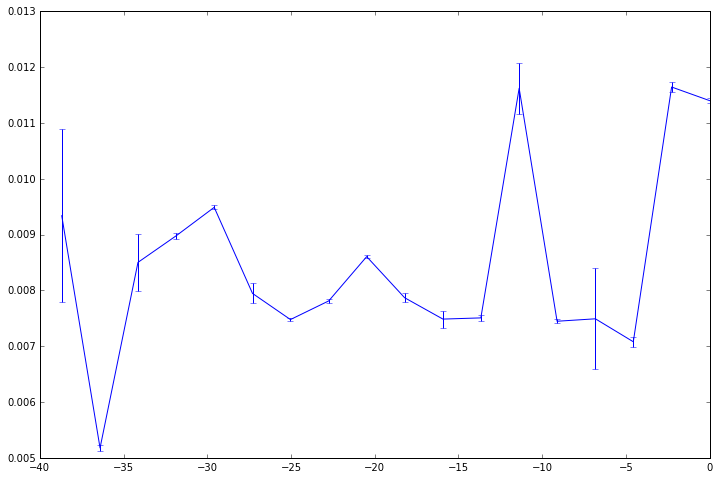

In [10]:
plt.errorbar(fits[:,0]*-11/0.5,fits[:,2],yerr=fits[:,7])
plt.errorbar(fits2[:,0]*11/0.5,fits2[:,2],yerr=fits2[:,7])

In [11]:
fits2 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW upper branch Rabi ')

In [12]:
fits3 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi  ')

In [13]:
print fits

[[  0.00000000e+00   1.98484879e+00   1.14012961e-02  -2.04952355e+01
    3.89888261e+03   6.29642532e-01   3.18346298e-01   4.77427708e-05
    2.25554036e+00   4.36818099e+03   9.82159304e-02]
 [  1.03000000e-01   1.02594605e+00   1.16448280e-02  -6.20758171e+01
    3.80548117e+03   8.14791019e+00   3.22858201e-01   9.13997922e-05
    3.99368826e+00   8.27887111e+03   9.87725816e-02]
 [  2.07000000e-01   2.74766881e+00   7.07948345e-03   2.33746263e+01
    4.47339261e+02   4.76568967e+00   5.26589714e-01   9.15405386e-05
    4.41794035e+00   1.16647491e+02   9.24094217e-02]
 [  3.10000000e-01   3.41881887e+00   7.49097693e-03   2.66489833e+01
    1.00000000e+02   7.77879920e+00   2.68584147e+00   9.06445357e-04
    1.63422374e+01   6.30904581e+01   9.57703784e-02]
 [  4.14000000e-01   4.72564448e+00   7.44719645e-03   7.55024974e+00
    7.62436204e+02   8.37564518e+00   4.01706584e-01   3.36468617e-05
    1.95024533e+00   1.18744310e+02   9.35729430e-02]
 [  5.17000000e-01   6.1997358

In [41]:
def EPR_NoRef(EPRfiles,pseq):
    files = glob.glob(EPRfiles)
    d_sum = np.zeros((pseq.shape[0],))
    l = pseq.shape[0]
    for f in files:
        epr = np.loadtxt(f)
        diff = epr[:,0]
        diff = np.nan_to_num(diff)
        diff.resize(((diff.shape[0] - (diff.shape[0] % l)),1))
        diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
        d_sum += np.mean(diff,axis=1)
        
    return pseq,d_sum

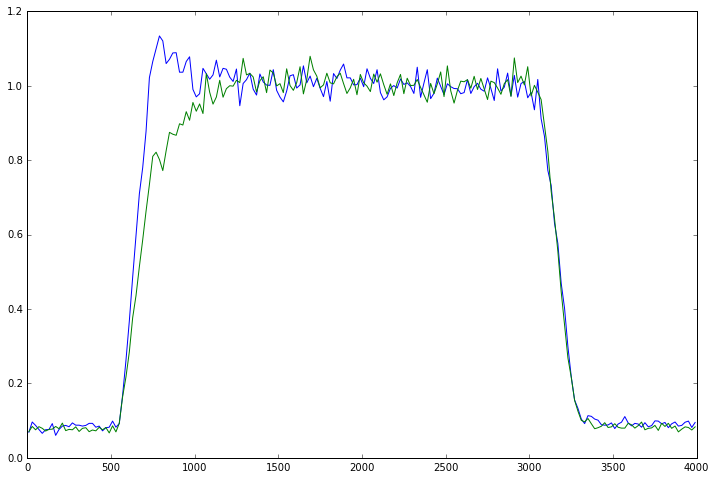

In [84]:
time = np.arange(10,4000,20)
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-3-16\Dot 1 Pulse delay test 5mW 5',time)
o = o/np.mean(o[100:130])
plt.plot(t,o)

time = np.arange(10,4000,20)
t,op = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-3-16\Dot 1 Pulse delay test 5mW 4 pi',time)
op = op/np.mean(op[100:130])
plt.plot(t,op)

(500, 2000)

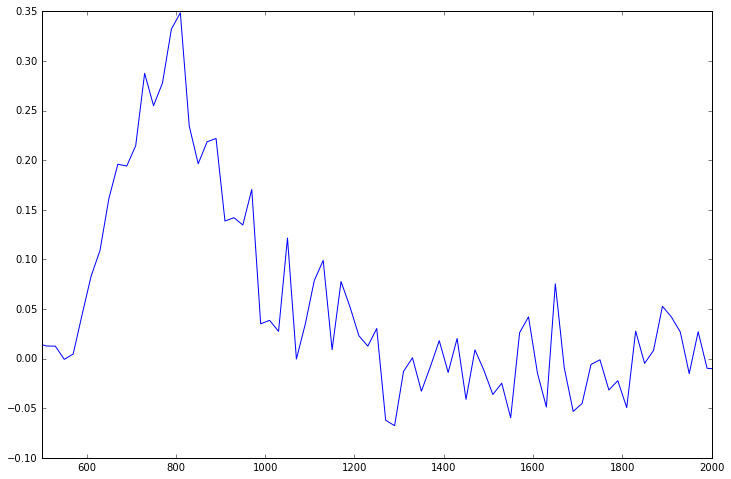

In [86]:
plt.plot(t,o-op)
plt.xlim([500,2000])


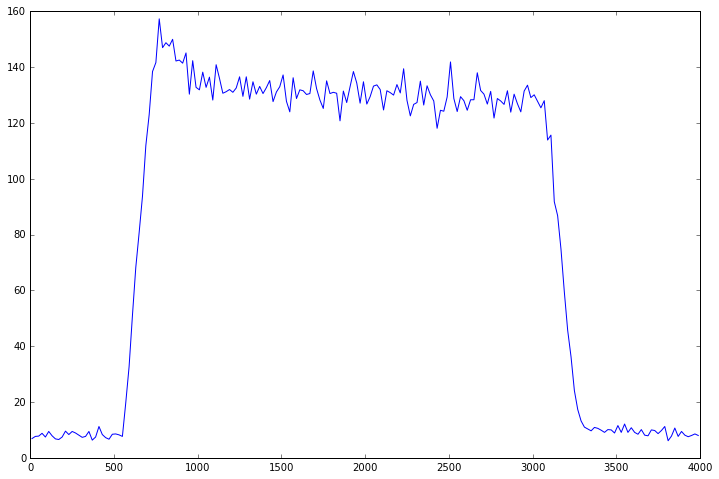

In [17]:
time = np.arange(10,4000,20)
t,o3 = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-3-16\Dot 1 Pulse delay test 1.25mW',time)
plt.plot(t,o3)

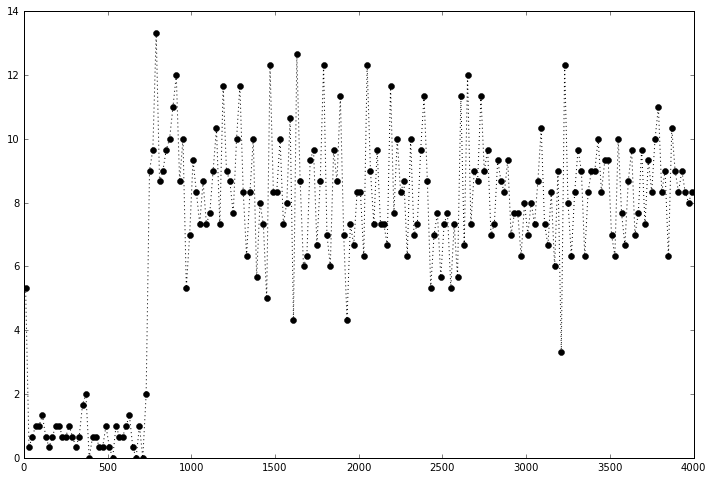

In [38]:
time = np.arange(10,4000,20)
t,o3 = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-6-16\5mW Dot 1 test scan',time)
plt.plot(t,o3,'ko:')

In [187]:
t2,o2 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-3-16\Dot 1 B0.414V T1 1500s scan 2 *[0-9]',r'C:\Users\Ouyang Group\Documents\Data\6-3-16\Dot 1 B0.414V T1 1500s scan 2 Pulse Seq')

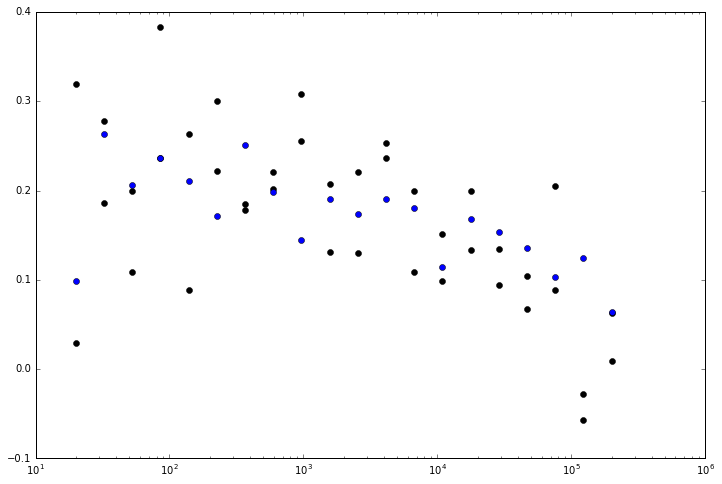

In [188]:
plt.semilogx(t,o,'ko')
plt.semilogx(t2,o2,'bo')

In [21]:
def lorentzian_2(X,a,x0,c):
    return a*c**2/(np.pi*c*(c**2+(X-x0)**2))

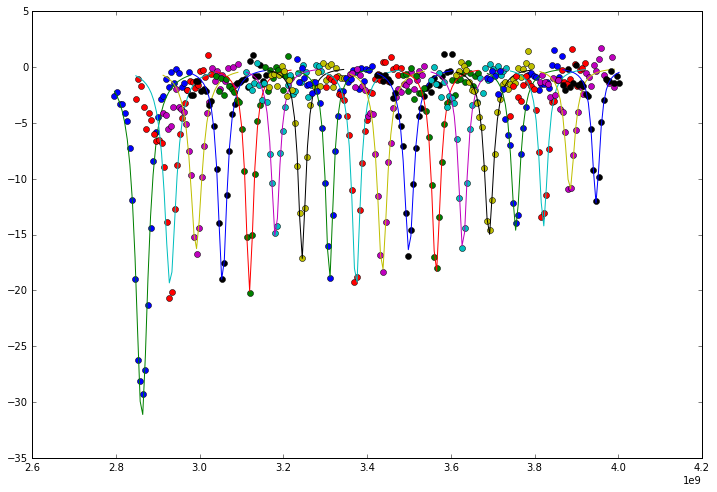

In [22]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW local ODMR upper *V ODMR')
res = np.zeros((len(files),2))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,3.2E9,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))
    

In [23]:
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW local ODMR upper freq fit.txt',res,fmt='%f',delimiter='\t')

In [24]:
fits4 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-4-16\Nabond on CPW 5mW scan 2 Dot 2 upper branch Rabi scans 2  ')

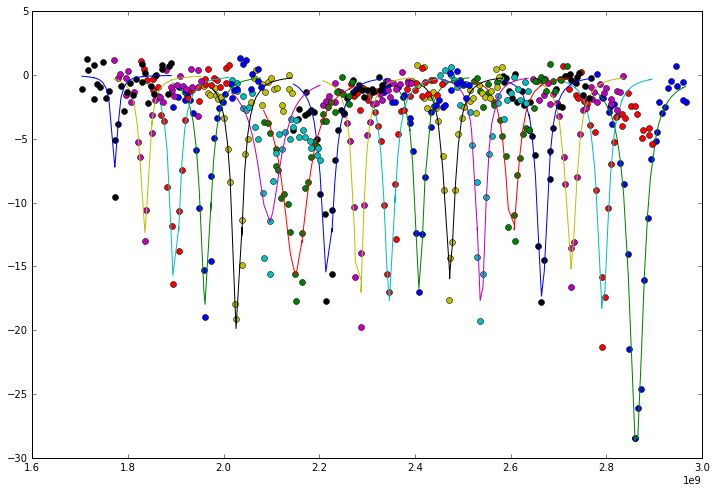

In [87]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot1 lower freq local ODMR*V ODMR')
res = np.zeros((len(files),2))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,3.2E9,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))

In [26]:
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW local ODMR lower freq fit & rabi.txt'
           ,np.vstack((fits[:,0],res[:,1],fits[:,2]*10**9)).T,fmt='%f',delimiter='\t')

In [88]:
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 5mW local ODMR lower freq fit.txt'
           ,res,fmt='%f',delimiter='\t')

In [27]:
fits

array([[  0.00000000e+00,   1.98484879e+00,   1.14012961e-02,
         -2.04952355e+01,   3.89888261e+03,   6.29642532e-01,
          3.18346298e-01,   4.77427708e-05,   2.25554036e+00,
          4.36818099e+03,   9.82159304e-02],
       [  1.03000000e-01,   1.02594605e+00,   1.16448280e-02,
         -6.20758171e+01,   3.80548117e+03,   8.14791019e+00,
          3.22858201e-01,   9.13997922e-05,   3.99368826e+00,
          8.27887111e+03,   9.87725816e-02],
       [  2.07000000e-01,   2.74766881e+00,   7.07948345e-03,
          2.33746263e+01,   4.47339261e+02,   4.76568967e+00,
          5.26589714e-01,   9.15405386e-05,   4.41794035e+00,
          1.16647491e+02,   9.24094217e-02],
       [  3.10000000e-01,   3.41881887e+00,   7.49097693e-03,
          2.66489833e+01,   1.00000000e+02,   7.77879920e+00,
          2.68584147e+00,   9.06445357e-04,   1.63422374e+01,
          6.30904581e+01,   9.57703784e-02],
       [  4.14000000e-01,   4.72564448e+00,   7.44719645e-03,
          7.55

In [58]:
t,o = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-6-16\0.5mW Dot 1 T1 scan 2 B0V 3000s *[0-9]',
          r'C:\Users\Ouyang Group\Documents\Data\6-6-16\0.5mW Dot 1 T1 scan 2 B0V 3000s Pulse Seq')
plt.semilogx(t[1:],o[1:],'ko')

C:\Users\Ouyang Group\Anaconda2\lib\site-packages\numpy\lib\npyio.py:891: UserWarning: loadtxt: Empty input file: "C:\Users\Ouyang Group\Documents\Data\6-6-16\0.5mW Dot 1 T1 scan 2 B0V 3000s Pulse Seq"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


ZeroDivisionError: long division or modulo by zero

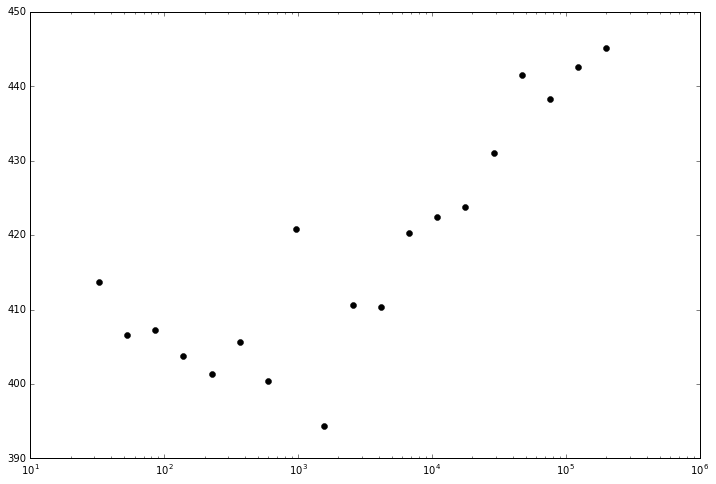

In [42]:
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-6-16\5mW Dot 1 T1 scan 2 B0V 3000s *[0-9]',
          np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-6-16\5mW Dot 1 T1 scan 2 B0V 3000s Pulse Seq'))
plt.semilogx(t[1:],o[1:],'ko')

<Container object of 3 artists>

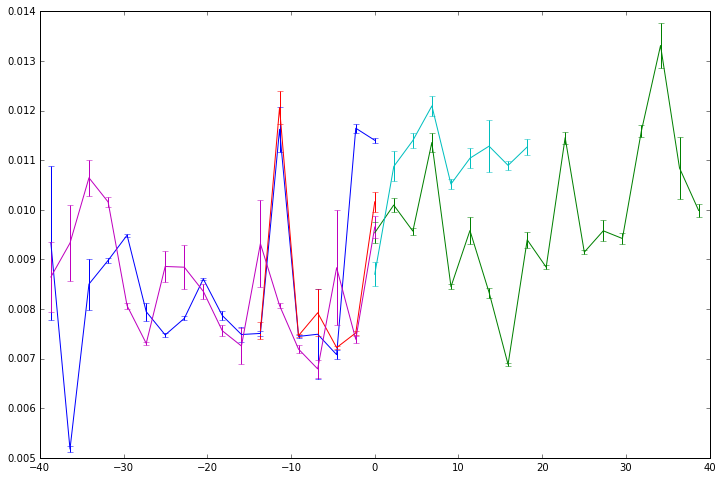

In [165]:
plt.errorbar(fits[:,0]*-11/0.5,fits[:,2],yerr=fits[:,7])
plt.errorbar(fits2[:,0]*11/0.5,fits2[:,2],yerr=fits2[:,7])
plt.errorbar(fits3[:,0]*-11/0.5,fits3[:,2],yerr=fits3[:,7])
plt.errorbar(fits4[:,0]*11/0.5,fits4[:,2],yerr=fits4[:,7])
plt.errorbar(fits5[:,0]*-11/0.5,fits5[:,2],yerr=fits5[:,7])


[  1.85903848e+00   7.41805870e-03   1.04492181e+01  -8.32080035e+09
   5.20849821e+00]


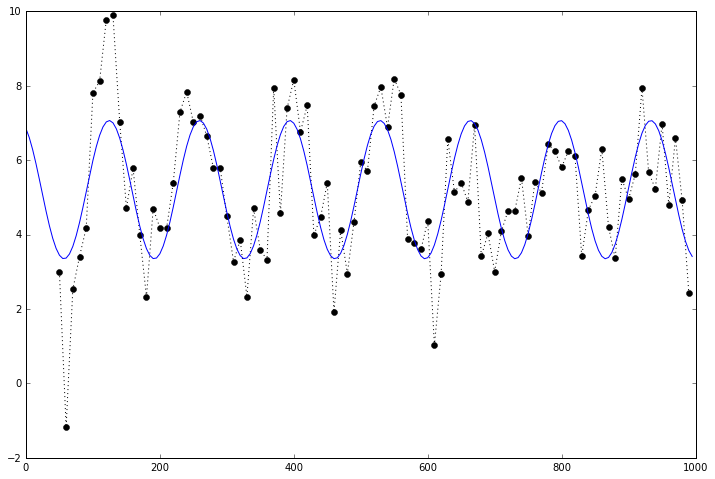

In [155]:
time,rabi0 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 20mW Rabi 3 x82 y127 750 sec 0.103000 V  *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 20mW Rabi 3 x82 y127 750 sec 0.103000 V   Pulse Seq')
rabi0 = 100*rabi0
opt0,cov0 = curve_fit(RabiFit,time[1:],rabi0[1:],maxfev=2500,p0=(6,8E-3,0,2000,-3))
plt.plot(time,rabi0,'ko:')
t = np.arange(0,1000,5)
plt.plot(t,RabiFit(t,*opt0),'b-')
print opt0

In [163]:
fits5 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 20mW Rabi 3 ')

In [167]:
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 20mW local ODMR lower freq fit & rabi.txt'
           ,np.vstack((fits5[:,0],res[:,1],fits5[:,2]*10**9)).T,fmt='%f',delimiter='\t')

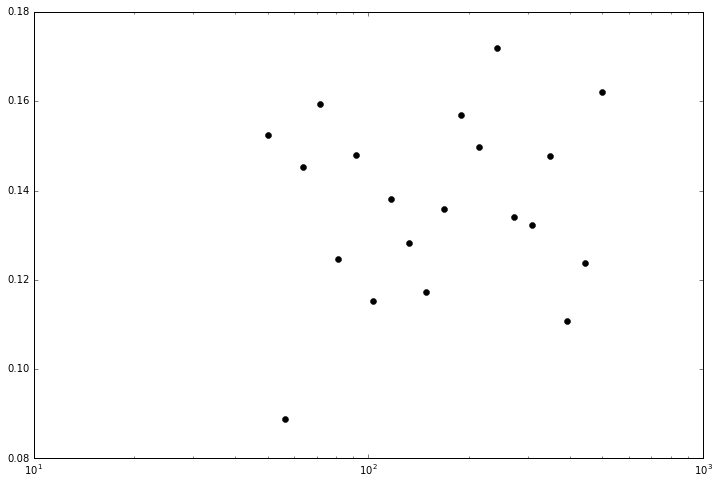

In [199]:
t3,o3 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 2mW T1 3  x89 y117 3600 sec 0.000000 V *[0-9]',
            r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 2mW T1 3  x89 y117 3600 sec 0.000000 V   Pulse Seq')
plt.semilogx(t3,o3,'ko')

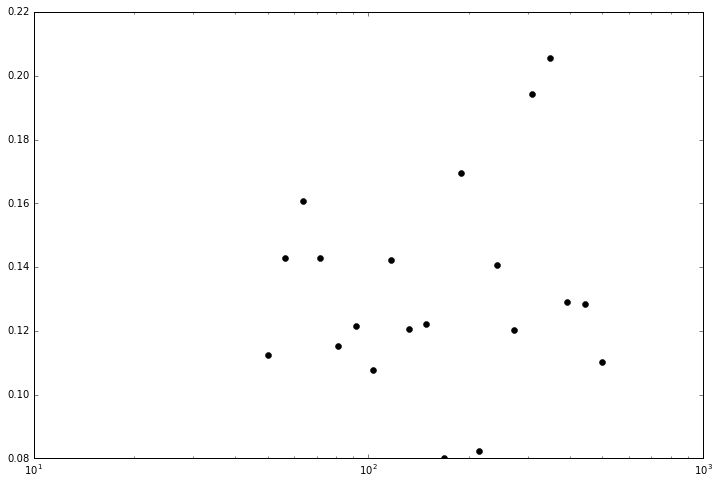

In [202]:
t3,o3 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 2mW T1 3  x97 y106 3600 sec 0.210526 V *[0-9]',
            r'C:\Users\Ouyang Group\Documents\Data\6-7-16\Dot 1 2mW T1 3  x97 y106 3600 sec 0.210526 V   Pulse Seq')
plt.semilogx(t3,o3,'ko')

In [8]:
fits6 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 1 20mW upper Rabi 2  ')